## Vehicle Detection using HOG and SVM



In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.pipeline import Pipeline

from moviepy.editor import VideoFileClip

import pickle
import os
import glob
import time

from  vehicle_detector import *

%matplotlib inline

In [15]:
from utils import *

In [16]:
DATA_DIR     = '/Users/aa/Developer/datasets/udacity-vehicle-detection/'
CAR_DIR      = DATA_DIR + 'vehicles/'
NON_VEHICLES = DATA_DIR + 'non-vehicles/'
MODEL_DIR    = './model/'

In [17]:
print('Looking for images: ', DATA_DIR)
images =    glob.glob(DATA_DIR + '**/*.png', recursive=True)   # For Larger dataset
# images =    glob.glob(LOCAL_DATA_DIR + '**/*.jpeg', recursive=True)    # for LOCAL dataset
print('Images len:  ', len(images))

cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image or 'non-vehicles_smallset' in image:
        notcars.append(image)
    else:
        cars.append(image)

print('Cars len    :', len(cars))
print('Non-cars len:', len(notcars))

Looking for images:  /Users/aa/Developer/datasets/udacity-vehicle-detection/
Images len:   17760
Cars len    : 8792
Non-cars len: 8968


This is a balanced dataset.

## Exploratory Data Analysis

In [18]:
from utils import *

In [19]:
def show_sample_data(data, title):
    plt.figure(figsize=(10,5))
    counter = 1
    samples = 5
    
    for i in range(samples):
        plt.subplot(1, samples, counter)
        counter += 1
        img = random_image(data)
        plt.imshow(img)
        plt.title('{}'.format(title))
        plt.axis('off')

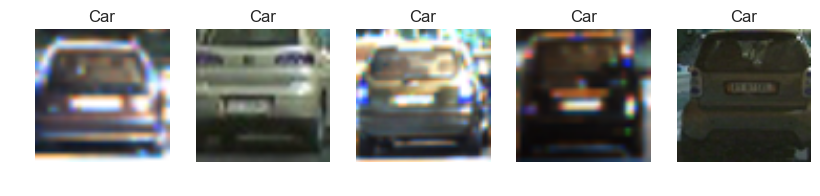

In [20]:
show_sample_data(cars, "Car")

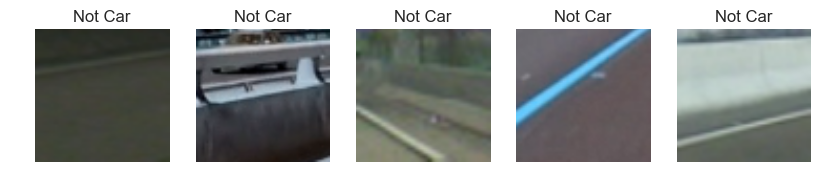

In [21]:
show_sample_data(notcars, "Not Car")

### Show HOG Features

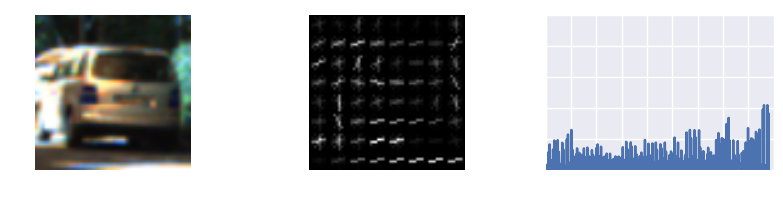

In [22]:
# car image with hog
car_img = random_image(cars)
gray = cv2.cvtColor(car_img, cv2.COLOR_BGR2GRAY)
hog_features, hog_img = get_hog_features(gray, orient=9,
                                        pix_per_cell=8,
                                        cell_per_block=2, vis=True)
show_hog_sample(car_img, hog_img, hog_features)

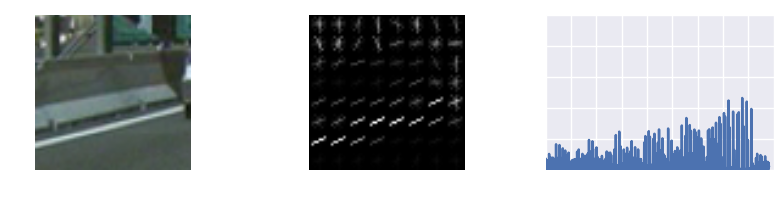

In [23]:
# Non-car image with hog
notcar_img = random_image(notcars)
gray = cv2.cvtColor(notcar_img, cv2.COLOR_BGR2GRAY)
hog_features, hog_img = get_hog_features(gray, orient=9,
                                        pix_per_cell=8,
                                        cell_per_block=2, vis=True)
show_hog_sample(notcar_img, hog_img, hog_features)

### Color Histogram

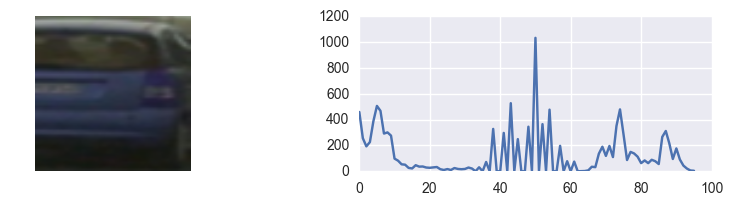

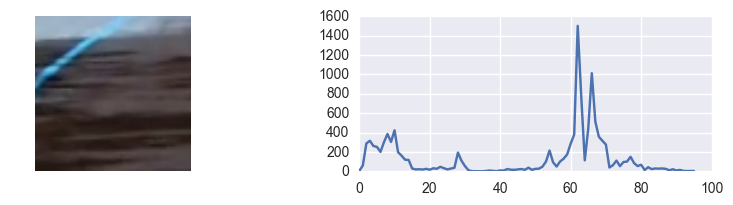

In [26]:
def histo_sample(img, color_img):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(color_hist(color_img))
    plt.show()

# Car color histogram
car_img = random_image(cars)
car_color_space = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
histo_sample(car_img, car_color_space)

# Not Car color histogram
notcar_img = random_image(notcars)
notcat_color = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2YCrCb)
histo_sample(notcar_img, notcat_color)

## Configuration 


In [27]:
### Tweak these parameters and see how the results change.
color_space     = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient          = 9  # HOG orientations
pix_per_cell    = 8 # HOG pixels per cell
cell_per_block  = 2 # HOG cells per block
hog_channel     = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size    = (32, 32) # Spatial binning dimensions
hist_bins       = 32    # Number of histogram bins
spatial_feat    = True # Spatial features on or off
hist_feat       = True # Histogram features on or off
hog_feat        = True # HOG features on or off
y_start_stop    = [400, 680] # Min and max in y to search in slide_window()

print('Using:', 
    color_space, ' color_space, ', 
    orient,'orientations, ',
    pix_per_cell, 'pixels/cell,', 
    cell_per_block,'cells/block, ',
    'hog_channel:', hog_channel,
    ',hist_bins:', hist_bins,
    ',spatial_size:', spatial_size,
    ',y_start_stop:', y_start_stop )

Using: YCrCb  color_space,  9 orientations,  8 pixels/cell, 2 cells/block,  hog_channel: ALL ,hist_bins: 32 ,spatial_size: (32, 32) ,y_start_stop: [400, 680]


## Feature Extraction 

Using the above configuration, we extract features from the dataset.
Note that depending on the config, we get anywhere from ~4500 to 9000 features for each image. 


In [28]:
t0 = time.time()

car_features = extract_features(cars, 
                        color_space=color_space, 
                        spatial_size=spatial_size, 
                        hist_bins=hist_bins, 
                        orient=orient, 
                        pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, 
                        hog_feat=hog_feat)

t1 = time.time()
print('  Car features done   : in {0} secs'.format(round(t1-t0, 2)))

notcar_features = extract_features(notcars, 
                        color_space=color_space, 
                        spatial_size=spatial_size, 
                        hist_bins=hist_bins, 
                        orient=orient, 
                        pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, 
                        hog_feat=hog_feat)
                    
t2 = time.time()
print('  Notcar features done: in {0} secs'.format(round(t2-t1, 2)))
print('Features :', len(car_features[0]))

  Car features done   : in 41.84 secs
  Notcar features done: in 38.45 secs
Features : 8460


In [29]:
## Stack up the data
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Using PCA for Dimensionality Reduction

Since we have about ~8500 features for each image, it could take a lot of time. Therefore, we evaluate whether PCA dimension reduction might be beneficial.


In [30]:
TOGGLE_PCA   = True # Toggle switch: True (do PCA); False (dont do PCA)

def perform_pca(X, n_comp=128, show_plot=False):
    ''' Perform PCA on the given features X, and return a reduced size of X (the principal components)
        :param X:   the scaled feature vector X
        :param n_comp:  number of PCA components to collapse into

        :return     pca (the transformer) 
        :return     and the PCA of X
    '''
    
    
    pca = PCA(n_components=n_comp, whiten=True)
    pca = pca.fit(X)
    pca_features = pca.transform(X)

    explained_variance = pca.explained_variance_ratio_
    components = pca.components_
    print("Explained variance by {} principal components: {:.4f}".format(n_comp, sum(explained_variance[:n_comp])))

    if show_plot is True:
        # plot PCA explanation
        plt.subplot(2, 1, 1)
        plt.xlabel('Dimension')
        plt.ylabel('Explained Variance')
        plt.title('Explained Variances of PCA')
        plt.plot(pca.explained_variance_ratio_)

        plt.subplot(2, 1, 2)
        plt.xlabel('Dimension')
        plt.ylabel('Cumu. Explained Variance')
        plt.title('Cumulative Explained Variances of PCA')
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.show()

    return pca, pca_features

Explained variance by 64 principal components: 0.4643


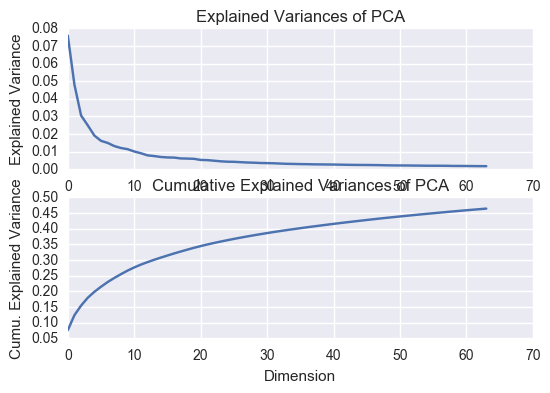

In [32]:
rand_state = np.random.randint(0, 100)
if TOGGLE_PCA:
    ## Perform PCA on scaled_X
    pca_transformer, X_pca = perform_pca(scaled_X, n_comp=64, show_plot=True)

    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, 
                                                        test_size=0.2, random_state=rand_state)
else:  
    print('NOT performing PCA')
    pca_transformer = None
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size=0.2, random_state=rand_state)

In [33]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test:  ', X_test.shape)
print('y_test:  ', y_test.shape)


X_train:  (14208, 64)
y_train:  (14208,)
X_test:   (3552, 64)
y_test:   (3552,)


We can see that the number of features have reduced to 64, from the original 8460

## Train a Classifier

Now we train a classifier to classify the images between Cars and Not-Cars.

In [34]:
## Fit the model
# Use a  SVC 
if TOGGLE_PCA:
    svc = SVC(C=10.0, kernel='rbf', gamma=0.01)      
else:
    svc = LinearSVC(C=0.08, loss='hinge')
    
# Check the training time for the SVC
t3  = time.time()

print(svc)
### Train the Classifier

svc.fit(X_train, y_train)

t4  = time.time()
print('Train time:', round(t4-t3, 2), ' secs')

# Check the score of the SVC
print('>> Test Accuracy of SVC: ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t5  = time.time()
print('Test  time:', round(t5-t4, 2), ' secs')

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Train time: 1.74  secs
>> Test Accuracy of SVC:  0.9975
Test  time: 0.3  secs


#### Accuracy
We get a pretty good accuracy of 99.75%.  Since this is good, we will save the model. 

### Save Model 

In [36]:
def save_model(clf, scaler, pca_transformer, featureX, labelsY):
    ''' Save classifier and scaler, and features/labels
    '''
    loc = time.localtime()
    msg = str(loc.tm_mon) + '_' + str(loc.tm_mday) + '_' + str(loc.tm_hour) + '_' + str(loc.tm_min)
    PICKLE_FILE     = MODEL_DIR + 'model_' + msg + '.pkl'
    # save info
    if TOGGLE_PCA:
        dump_data = {
            "clf":      clf,     # the classifier
            "scaler":   scaler,  # scaler
            "do_pca":   True,    # YES, do PCA
            "pca":      pca_transformer
        }
    else:
        dump_data = {
            "clf":      clf,     # the classifier
            "scaler":   scaler,  # scaler
            "do_pca":   False    # NO PCA
        }
    with open(PICKLE_FILE, 'wb') as PF:
        pickle.dump(dump_data, PF)
        print('Model saved:   ', PICKLE_FILE)

In [37]:
## Save Model, Scaler and  Features/Labels
save_model(svc, X_scaler, pca_transformer, scaled_X, y)

Model saved:    ./model/model_3_10_20_44.pkl


## Testing on Static Images

In [41]:
# Create a Vehicle Detector
heat_threshold = 1

vehicle_detector = VehicleDetector(
        color_space=color_space,
        orient=orient,
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        hog_channel=hog_channel,
        spatial_size=spatial_size,
        hist_bins=hist_bins,
        spatial_feat=spatial_feat,
        hist_feat=hist_feat,
        hog_feat=hog_feat,
        x_start_stop=[None, None],
        y_start_stop=y_start_stop,
        xy_window=(96, 96),
        xy_overlap=(0.75, 0.75),
        heat_threshold=heat_threshold,
        clf=svc,           
        scaler=X_scaler, 
        pca=pca_transformer)

vehicle_detector.print()

----------------------------------------
[color=YCrCb, orient=9, pix/cell=8, cell/bk=2, hog=ALL
 spatial_size=(32, 32), hist_bins=32, y_start_stop=[400, 680], xy_window=(96, 96), xy_overlap=(0.75, 0.75) thresh=1]
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
PCA: PCA(copy=True, iterated_power='auto', n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)
----------------------------------------


Running test..


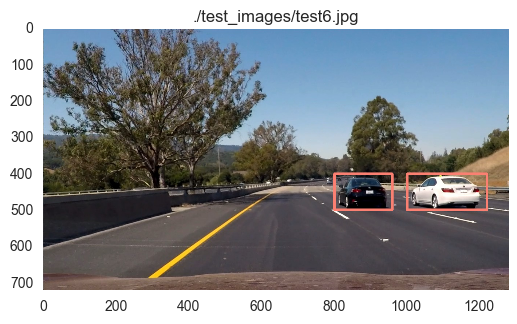

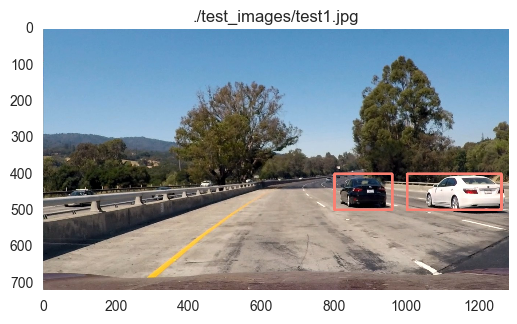

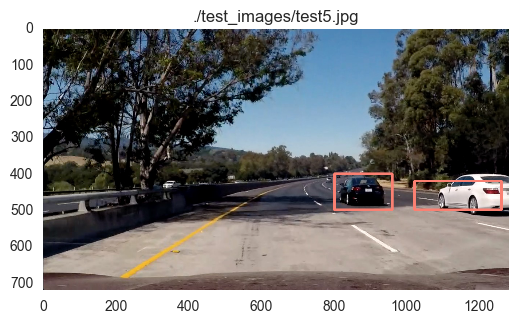

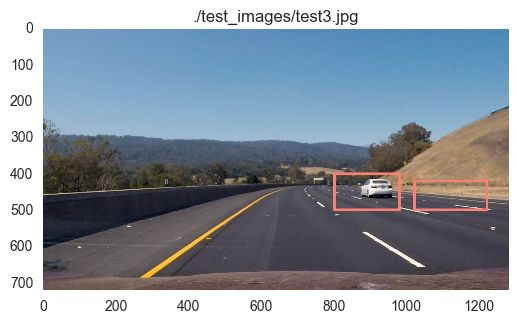

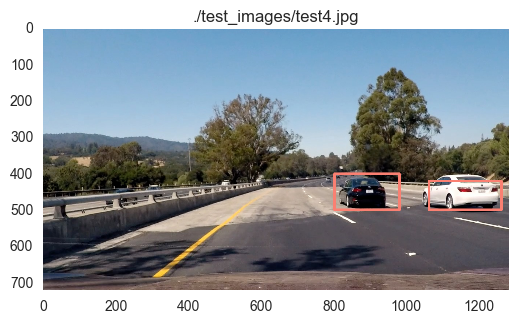

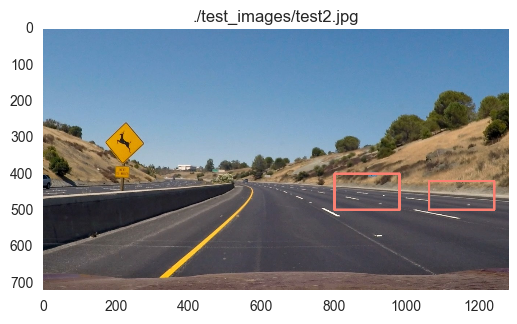

In [44]:
test_images = [
        './test_images/test6.jpg',
        './test_images/test1.jpg',
        './test_images/test5.jpg',
        './test_images/test3.jpg',
        './test_images/test4.jpg',
        './test_images/test2.jpg'
        ]
print('Running test..')

for test_img in test_images:
    imgtest = mpimg.imread(test_img)
    out_img = vehicle_detector.process_frame(imgtest, show_box=False, show_heatmap=False)
    plt.imshow(out_img)
    plt.title(test_img)
    plt.grid('off')
    plt.show()

### Results

We can see that the classifier does a pretty good job of detecting cars on the road. 
It does show some false positives (which is likely due to the buffer maintained in the Vehicle detector that remembers previous detections).

### Sliding Window Search

Let's see how the Sliding Window Search algorithm works.

Running test..


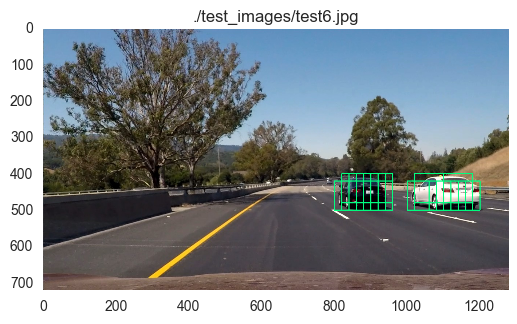

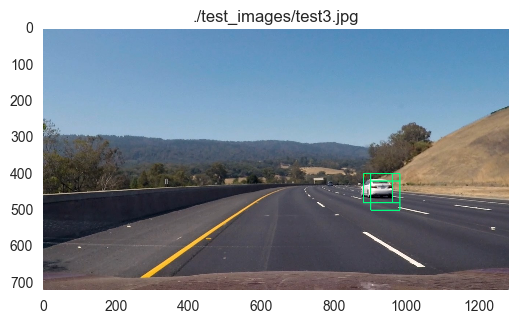

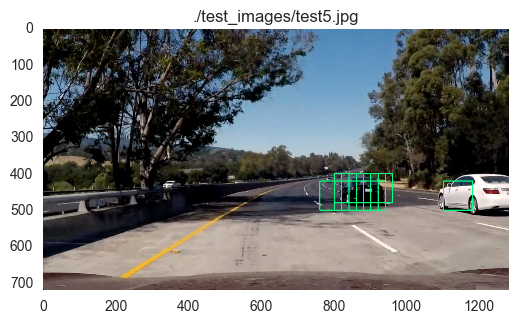

In [45]:
test_images = [
        './test_images/test6.jpg',
        './test_images/test3.jpg',
        './test_images/test5.jpg',

        ]
print('Running test..')

for test_img in test_images:
    imgtest = mpimg.imread(test_img)
    out_img = vehicle_detector.process_frame(imgtest, show_box=True, show_heatmap=False)
    plt.imshow(out_img)
    plt.title(test_img)
    plt.grid('off')
    plt.show()

## Heatmap

Let's see some of the heatmaps 

Running test..


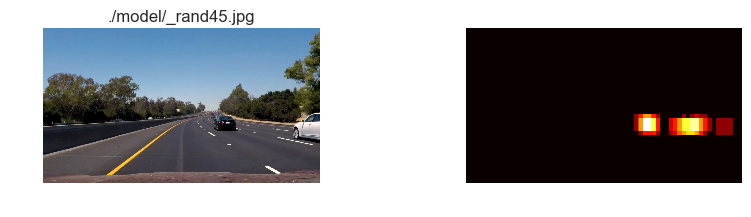

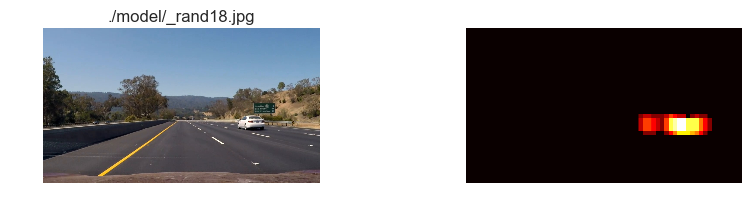

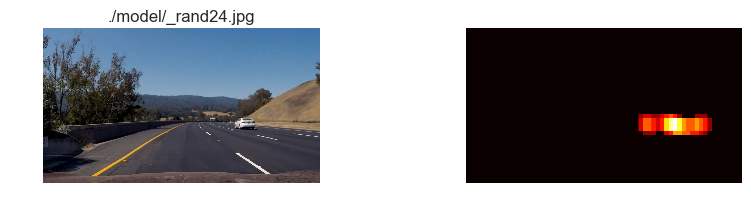

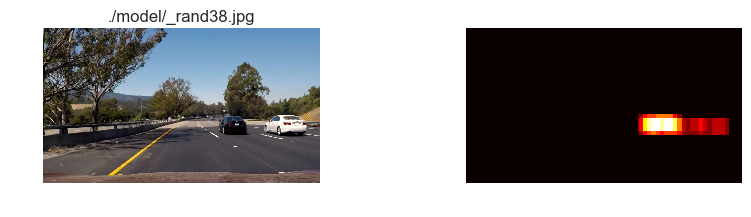

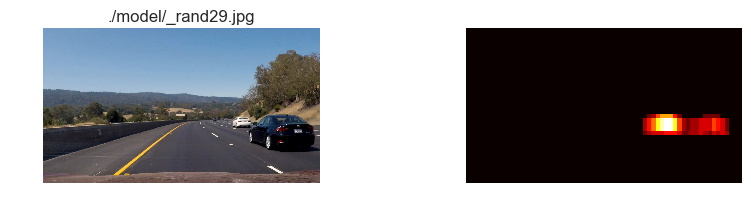

In [54]:
test_images = [
        './model/_rand45.jpg',
        './model/_rand18.jpg',
        './model/_rand24.jpg',
        './model/_rand38.jpg',
        './model/_rand29.jpg',
        ]
print('Running test..')

for test_img in test_images:
    imgtest = mpimg.imread(test_img)
    out_img = vehicle_detector.process_frame(imgtest, show_box=False, show_heatmap=True)
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(imgtest)
    plt.title(test_img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(out_img, cmap='hot')
    plt.axis('off')
    plt.show()
    